In [1]:
%pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import cv2
from os.path import join
from glob import glob
import matplotlib.pyplot as plt
import skimage
import time
import math
from tqdm.notebook import tqdm
from skimage.morphology import skeletonize,dilation,erosion,square
from skimage.util import invert

import fingerprint as fp

In [3]:
plt.rcParams['figure.figsize']=(5,5)

## 하나로 먼저 테스트

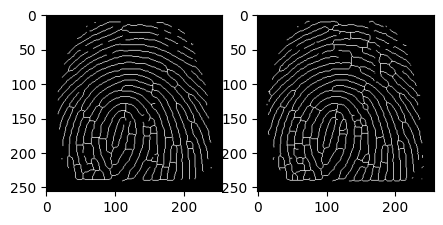

In [4]:
img1=cv2.imread('train/1.BMP',0)
blur_img=cv2.medianBlur(img1,5)
blur_img=cv2.medianBlur(blur_img,5)

binary_img = cv2.adaptiveThreshold(blur_img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
binary_img=255-binary_img
binary_img=cv2.medianBlur(binary_img,5)

#kernel=np.ones((1,1),np.uint8)
#binary_img=cv2.erode(img,kernel,iterations=1)

#binary_img=erosion(binary_img,square(3))

binary_img=dilation(binary_img,square(3))
binary_img=erosion(binary_img,square(3))

sk_image=skeletonize(binary_img//255)
sk_image=sk_image.astype(np.uint8)
sk_image[sk_image==1]=255

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(sk_image, cv2.COLOR_GRAY2RGB))

img2=cv2.imread('test2/1_type2.BMP',0)
blur_img2=cv2.medianBlur(img2,5)
blur_img2=cv2.medianBlur(blur_img2,5)

binary_img2 = cv2.adaptiveThreshold(blur_img2,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
binary_img2=255-binary_img2
blur_img2=cv2.medianBlur(blur_img2,5)

#kernel=np.ones((1,1),np.uint8)
#binary_img=cv2.erode(img,kernel,iterations=1)

#binary_img=erosion(binary_img,square(3))

binary_img2=dilation(binary_img2,square(3))
binary_img2=erosion(binary_img2,square(3))

sk_image2=skeletonize(binary_img2//255)
sk_image2=sk_image2.astype(np.uint8)
sk_image2[sk_image2==1]=255

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(sk_image2, cv2.COLOR_GRAY2RGB))

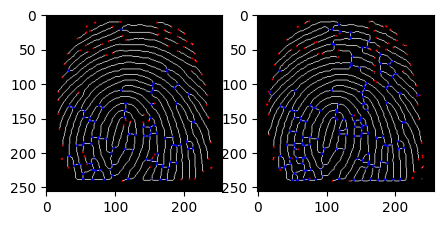

In [5]:
def get_fp_feature(img):
    minutiae_end = []
    minutiae_bif = []

    neighbors = [(-1, -1), (-1, 0), (-1, 1), 
                 (0, -1),          (0, 1), 
                 (1, -1), (1, 0), (1, 1)]

    rows, cols = img.shape
    for i in range(1, rows-1):
        for j in range(1, cols-1):
            if img[i, j] == 255:
                block = [img[i + dx, j + dy] for dx, dy in neighbors]
                block_val=np.sum(block)//255
                
                if block_val == 1:
                    minutiae_end.append((i, j))
                elif block_val == 3:
                    minutiae_bif.append((i, j))

    return minutiae_end, minutiae_bif

minutiae_end, minutiae_bif=get_fp_feature(sk_image)
feature=np.concatenate([minutiae_end,minutiae_bif]).astype(np.uint8)
features={}
basename='/train/1.BMP'
basename2='test2/1_type2.BMP'
features[basename]=feature

minutiae_end2, minutiae_bif2=get_fp_feature(sk_image2)
feature2=np.concatenate([minutiae_end2,minutiae_bif2]).astype(np.uint8)
features2={}
features2[basename2]=feature2

feat_train=np.concatenate([minutiae_end,minutiae_bif]).astype(np.uint8)
feat_test=np.concatenate([minutiae_end2, minutiae_bif2]).astype(np.uint8)

#print(features[basename])
#print(minutiae_end[:5])
#print(minutiae_bif[:5])

def plot_minutiae(img, end, bif):
  # 원본 이미지에 특징점 찍기
  img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
  # end
  for (x,y) in end:
      cv2.circle(img_color, (y,x), 1, (255, 0, 0), -1)  # 끝점: 빨간색 점
  # bif
  for (x,y) in bif:
      cv2.circle(img_color, (y,x), 1, (0, 0, 255), -1)  # 분기점: 파란색 점

  return img_color


feature=plot_minutiae(sk_image, minutiae_end, minutiae_bif)
feature2=plot_minutiae(sk_image2, minutiae_end2, minutiae_bif2)
plt.subplot(1,2,1)
plt.imshow(feature)
plt.subplot(1,2,2)
plt.imshow(feature2)


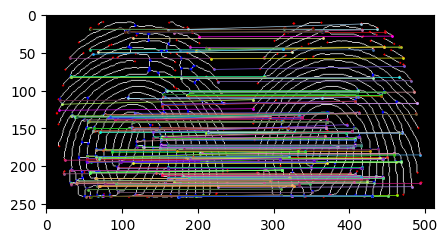

1.6924801938397367 137
CPU times: total: 2.05 s
Wall time: 4.78 s


In [6]:
%%time
def match_finger(feat_test, feat_train, threshold, draw=False, img_test=None, img_train=None):
    dists = []
    matches = []  
      
    for test_point in feat_test:
        min_dist = float('inf')
        matched_point = None

        for train_point in feat_train:
            dist = np.linalg.norm(np.array(test_point) - np.array(train_point))
            if dist < min_dist:
                min_dist = dist
                matched_point = train_point
                
        if min_dist <= threshold:
            dists.append(min_dist)
            matches.append((test_point, matched_point))

    
    max_dist=max(dists)
    min_dist=min(dists)
    avg_dist = np.mean(dists)
    len_match=len(matches)//2
    
    if draw and img_test is not None and img_train is not None:
        plt.figure()
        plt.imshow(np.hstack((img_test, img_train)))
        for m in matches:
          # 무작위 색상
            color = np.random.rand(3,)

        # 연결선 그리기
            plt.plot([m[0][1], m[1][1] + img_test.shape[1]], [m[0][0], m[1][0]], color=color, linewidth=0.5, linestyle='-')  # connection line (color determined by iterated color list, thinner line)
            plt.plot(m[0][1], m[0][0], marker='o', markersize=1, color=color)  # query point (color determined by iterated color list)
            plt.plot(m[1][1] + img_train.shape[1], m[1][0], marker='o', markersize=1, color=color)  # matched point in train image (color determined by iterated color list)
        plt.show()

    return avg_dist, len_match
avg_dist,len_match=match_finger(feat_test, feat_train, 10, True, img_test=feature2,img_train=feature) 
print(avg_dist,len_match)

In [7]:
train_path = 'train'
test_path = 'test2'

# 모든 BMP 파일 경로를 정렬하여 리스트에 저장
train = sorted(glob(join(train_path, '*.BMP')))
list_test = sorted(glob(join(test_path, '*.BMP')))

def load_images(folder_path):
    images = []
    image_names = []

    for img_name in sorted(os.listdir(folder_path)):
        img_path = os.path.join(folder_path, img_name)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            images.append(image)
            image_names.append(img_name)

    return np.array(images), image_names

def preprocess_image(img):
    blur_img=cv2.medianBlur(img,5)
    blur_img=cv2.medianBlur(blur_img,5)
    
    binary_img = cv2.adaptiveThreshold(blur_img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
    binary_img=255-binary_img
    binary_img=cv2.medianBlur(binary_img,5)

    binary_img=dilation(binary_img,square(3))
    binary_img=erosion(binary_img,square(3))
    
    sk_image=skeletonize(binary_img//255)
    sk_image=sk_image.astype(np.uint8)
    sk_image[sk_image==1]=255
    sk_image=cv2.cvtColor(sk_image,cv2.COLOR_GRAY2RGB)
    return sk_image

def preprocess_and_save_images(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    images, image_names = load_images(input_folder)
    for img, img_name in tqdm(zip(images, image_names), desc="Preprocessing images", total=len(images)):
        preprocessed_img = preprocess_image(img)
        save_path = os.path.join(output_folder, img_name)
        cv2.imwrite(save_path, preprocessed_img)  

# Preprocess images
train_folder = 'train'
test_folder = 'test2'
preprocessed_train_folder = 'preprocessed_train'
preprocessed_test_folder = 'preprocessed_test2'

preprocess_and_save_images(train_folder, preprocessed_train_folder)
preprocess_and_save_images(test_folder, preprocessed_test_folder)


Preprocessing images:   0%|          | 0/477 [00:00<?, ?it/s]

Preprocessing images:   0%|          | 0/1428 [00:00<?, ?it/s]

In [8]:
def get_fp_feature(img):
    minutiae_end = []
    minutiae_bif = []

    neighbors = [(-1, -1), (-1, 0), (-1, 1), 
                 (0, -1),          (0, 1), 
                 (1, -1), (1, 0), (1, 1)]

    rows, cols = img.shape
    for i in range(1, rows-1):
        for j in range(1, cols-1):
            if img[i, j] == 255:
                block = [img[i + dx, j + dy] for dx, dy in neighbors]
                block_val=np.sum(block)//255
                
                if block_val == 1:
                    minutiae_end.append((i, j))
                elif block_val == 3:
                    minutiae_bif.append((i, j))

    return minutiae_end, minutiae_bif
    
def plot_minutiae(img, end, bif):
  # 원본 이미지에 특징점 찍기
  img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
  # end
  for (x,y) in end:
      cv2.circle(img_color, (y,x), 1, (255, 0, 0), -1)  # 끝점: 빨간색 점
  # bif
  for (x,y) in bif:
      cv2.circle(img_color, (y,x), 1, (0, 0, 255), -1)  # 분기점: 파란색 점

  return img_color

def extract_features_train(input_folder): 
    images, image_names = load_images(input_folder)
    train_features = {}
    for img, img_name in tqdm(zip(images, image_names), desc="Extracting features", total=len(images)):
        basename=os.path.basename(img_name)
        skeleton_img = cv2.imread(os.path.join(input_folder, img_name), cv2.IMREAD_GRAYSCALE)
        minutiae_end, minutiae_bif = get_fp_feature(skeleton_img)
        feature_train=np.concatenate([minutiae_end,minutiae_bif]).astype(np.uint8)
        #feature_img=plot_minutiae(skeleton_img, minutiae_end, minutiae_bif)  # Visualize minutiae
        train_features[basename]=feature_train
    return train_features

images, image_names = load_images(preprocessed_train_folder)
train_features = {}
for img, img_name in tqdm(zip(images, image_names), desc="Extracting features", total=len(images)):
    basename=os.path.basename(img_name)
    skeleton_img = cv2.imread(os.path.join(preprocessed_train_folder, img_name), cv2.IMREAD_GRAYSCALE)
    minutiae_end, minutiae_bif = get_fp_feature(skeleton_img)
    feature_train=np.concatenate([minutiae_end,minutiae_bif]).astype(np.uint8)
    #feature_img=plot_minutiae(skeleton_img, minutiae_end, minutiae_bif)  # Visualize minutiae
    train_features[basename]=feature_train
        
def extract_features_test(input_folder):
    images, image_names = load_images(input_folder)
    test_features={}
    for img, img_name in tqdm(zip(images, image_names), desc="Extracting features", total=len(images)):
        basename=os.path.basename(img_name)
        skeleton_img = cv2.imread(os.path.join(input_folder, img_name), cv2.IMREAD_GRAYSCALE)
        minutiae_end, minutiae_bif = get_fp_feature(skeleton_img)
        feature_test=np.concatenate([minutiae_end,minutiae_bif]).astype(np.uint8)
        #feature_img=plot_minutiae(skeleton_img, minutiae_end, minutiae_bif)  # Visualize minutiae
        test_features[basename]=feature_test
    return test_features
    
images, image_names = load_images(preprocessed_test_folder)
test_features={}
for img, img_name in tqdm(zip(images, image_names), desc="Extracting features", total=len(images)):
    basename=os.path.basename(img_name)
    skeleton_img = cv2.imread(os.path.join(preprocessed_test_folder, img_name), cv2.IMREAD_GRAYSCALE)
    minutiae_end, minutiae_bif = get_fp_feature(skeleton_img)
    feature_test=np.concatenate([minutiae_end,minutiae_bif]).astype(np.uint8)
    #feature_img=plot_minutiae(skeleton_img, minutiae_end, minutiae_bif)  # Visualize minutiae
    test_features[basename]=feature_test


# Extract features from preprocessed images
#train_features=extract_features_train(preprocessed_train_folder)
#test_features=extract_features_test(preprocessed_test_folder)


Extracting features:   0%|          | 0/477 [00:00<?, ?it/s]

Extracting features:   0%|          | 0/1428 [00:00<?, ?it/s]

In [9]:
print(train_features['20.BMP'][0])

[ 11 162]


In [10]:
%%time
from scipy.spatial.distance import cdist

    
def match_fingerprints(train_features, test_features):
    matches = {}
    
    for test_name, test_feat in test_features.items():
        min_distance = float('inf')
        best_match = None
        
        for train_name, train_feat in train_features.items():
    
            if train_feat.shape != test_feat.shape:
                continue
            
            distance = np.linalg.norm(test_feat - train_feat)
            
            if distance < min_distance:
                min_distance = distance
                best_match = train_name
        
        matches[test_name] = best_match
    
    return matches

matches = match_fingerprints(train_features, test_features)

for test_name, train_name in matches.items():
    print(f'Test fingerprint {test_name} matches with Train fingerprint {train_name}')


Test fingerprint 100_type1.BMP matches with Train fingerprint 456.BMP
Test fingerprint 100_type2.BMP matches with Train fingerprint 181.BMP
Test fingerprint 100_type3.BMP matches with Train fingerprint 410.BMP
Test fingerprint 101_type1.BMP matches with Train fingerprint 445.BMP
Test fingerprint 101_type2.BMP matches with Train fingerprint 433.BMP
Test fingerprint 101_type3.BMP matches with Train fingerprint 543.BMP
Test fingerprint 102_type1.BMP matches with Train fingerprint 170.BMP
Test fingerprint 102_type2.BMP matches with Train fingerprint 446.BMP
Test fingerprint 102_type3.BMP matches with Train fingerprint 7.BMP
Test fingerprint 104_type1.BMP matches with Train fingerprint 104.BMP
Test fingerprint 104_type2.BMP matches with Train fingerprint None
Test fingerprint 104_type3.BMP matches with Train fingerprint None
Test fingerprint 105_type1.BMP matches with Train fingerprint None
Test fingerprint 105_type2.BMP matches with Train fingerprint None
Test fingerprint 105_type3.BMP mat